In [95]:
import pandas as pd
import numpy as np
import math

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [96]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [5]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

# Setup

## variables

In [6]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

In [7]:
# Functions

In [8]:
def r2(actual: np.ndarray, predicted: np.ndarray):
    """ R2 Score """
    return r2_score(actual, predicted)

def adjr2(actual: np.ndarray, predicted: np.ndarray, rowcount: int, featurecount: int):
    """ R2 Score """
    return 1-(1-r2(actual,predicted))*(rowcount-1)/(rowcount-featurecount)

def mse(actual, predicted):
    return mean_squared_error(actual, predicted)

def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

def model_results(actual, predicted, rowcount, featurecount):
    print('r-squared: ', round(r2(actual, predicted),4))
    print('adj r-squared', round(adjr2(actual,predicted,rowcount, featurecount),4))
    print('mse: ', round(mse(actual, predicted),4))
    print('rmse: ', round(rmse(actual, predicted),4))
    print('rmse: ', eval_measures.rmse(actual,predicted,axis=0))

In [126]:
def get_fed_chair():
    df = pd.read_csv('./data/Fed_Chair.csv', parse_dates=['Start_Date','End_Date'])
    df['End_Date'].fillna(pd.Timestamp.now().normalize(), inplace=True)
    df = df[(df['Start_Date'] >= '1955-01-01')]
    return df

def fed_chair(df, chair_df):
    
    df.reset_index(inplace=True)

    df['chair_name'] = None
    for i, row in chair_df.iterrows():
        df['chair_name'] = df['chair_name'].where((df['DATE'] < row['Start_Date']) | (df['DATE'] > row['End_Date']), row['Name'] )
    
    df.set_index('DATE',inplace=True)
    return df

In [125]:
def get_recession():
    recession_df = pd.read_csv('./data/FRED_Recession_Bars.csv', parse_dates=['Peak_Date','Trough_Date'])
    return recession_df[(recession_df['Peak_Date'] >= '1955-01-01')]


def add_recession_feature(date, recession_df):
    for i,row in recession_df.iterrows():
        if row['Peak_Date'] <= date <= row['Trough_Date']:
            return True
    return False


In [68]:


def load_taylor():
    
    gdpc1_df = pd.read_csv('./data/GDPC1.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdpc1_df:', gdpc1_df.shape)
    gdppot_df = pd.read_csv('./data/GDPPOT.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdppot_df:', gdppot_df.shape)
    gdpdef_df = pd.read_csv('./data/GDPDEF.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdpdef_df:', gdpdef_df.shape)
    fed_df = pd.read_csv('./data/FEDFUNDS.csv', parse_dates=['observation_date'], skiprows=10)
    print('fed_df:', fed_df.shape)
    
    
    taylor_df = gdpc1_df.merge(gdppot_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                        .merge(gdpdef_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                        .merge(fed_df, how='outer', left_on='observation_date', right_on='observation_date')

    taylor_df.dropna(inplace=True)
    taylor_df
    
    
    #taylor_df = pd.DataFrame()
    taylor_df['ffef_tr'] = taylor_df['GDPDEF_PC1'] + 2    \
                            +0.5*(taylor_df['GDPDEF_PC1'] - 2)    \
                            +0.5*(taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100

    taylor_df['gap_inf'] = 0.5*(taylor_df['GDPDEF_PC1'] - 2) 
    taylor_df['gap_gdp'] = 0.5*(taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100

    taylor_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    
    
    r_df = get_recession()
    #$taylor_df.reset_index(inplace=True)
    taylor_df['recession_flag'] = taylor_df['DATE'].apply(add_recession_feature, args=(r_df,))
    taylor_df.set_index('DATE',inplace=True)
    #taylor_df
    #taylor_df = taylor_df.set_index('DATE')
    #taylor_df = add_recession_feature(taylor_df,r_df)
    
    f_df = get_fed_chair()
    fed_chair(taylor_df, f_df)
    
    
    return taylor_df



def load_misery():
    
    t_df = pdr.DataReader(['FEDFUNDS','CPIAUCSL', 'UNRATE'], data_source, start_date)
    t_df.dropna(inplace=True)
    print('t_df:', t_df.shape)

    #u_df = pd.read_csv('./data/CPIAUCSL.csv', parse_dates=['observation_date'], skiprows=10)
    #u_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    #u_df.set_index('DATE', inplace=True)
    u_df = pd.read_csv('./data/CPIAUCSL_PC1.csv', parse_dates=['DATE'])
    #u_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    u_df.set_index('DATE', inplace=True)
    print('u_df:', u_df.shape)

    misery_df = pd.merge(t_df,u_df, left_index=True, right_index=True )
    #misery_df['m_index'] = abs(misery_df['CPIAUCSL_CH1']) + misery_df['UNRATE']
    #misery_df['m_index'] = (misery_df['CPIAUCSL_CH1']) + misery_df['UNRATE']
    misery_df['m_index'] = (misery_df['CPIAUCSL_PC1']) + misery_df['UNRATE']
    print('misery_df:', misery_df.shape)  
    
    return misery_df



def time_split(df):
    t_df = df.copy()

    # Split Data
    splt_index = round(t_df.shape[0] * 0.8)
    train_df = t_df[:splt_index]
    print('train_df: ' , train_df.shape)

    end_index = splt_index - t_df.shape[0]
    test_df = t_df[end_index:]
    print('test_df: ' , test_df.shape)
    
    return train_df, test_df

# Dataset FRED Data

In [77]:
taylor_df = load_taylor()
taylor_df

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,ffef_tr,gap_inf,gap_gdp,recession_flag,chair_name
DATE,,,,,,,,,
1954-07-01,2880.482,2727.099666,0.7,0.80,4.862188,-0.65,2.812188,False,Martin
1954-10-01,2936.852,2743.726730,0.8,0.85,5.719397,-0.60,3.519397,False,Martin
1955-01-01,3020.746,2760.136280,1.0,1.39,7.220957,-0.50,4.720957,False,Martin
1955-04-01,3069.910,2777.950765,1.3,1.43,8.204939,-0.35,5.254939,False,Martin
1955-07-01,3111.379,2795.471543,1.9,1.68,9.500343,-0.05,5.650343,False,Martin
...,...,...,...,...,...,...,...,...,...
2022-04-01,21708.160,20153.810000,7.7,0.33,16.406219,2.85,3.856219,False,Powell
2022-07-01,21851.134,20245.660000,7.3,1.68,15.914983,2.65,3.964983,False,Powell
2022-10-01,21989.981,20334.210000,6.4,3.08,14.671392,2.20,4.071392,False,Powell


In [119]:
misery_df = load_misery()
misery_df

t_df: (832, 3)
u_df: (909, 1)
misery_df: (831, 5)


,FEDFUNDS,CPIAUCSL,UNRATE,CPIAUCSL_PC1,m_index
DATE,,,,,
1954-07-01,0.80,26.860,5.8,0.26129,6.06129
1954-08-01,1.22,26.850,6.0,0.00000,6.00000
1954-09-01,1.07,26.810,6.1,-0.29751,5.80249
1954-10-01,0.85,26.720,5.7,-0.85343,4.84657
1954-11-01,0.83,26.780,5.3,-0.26071,5.03929
...,...,...,...,...,...
2023-05-01,5.06,303.294,3.7,4.12884,7.82884
2023-06-01,5.08,303.841,3.6,3.09200,6.69200
2023-07-01,5.12,304.348,3.5,3.29908,6.79908


In [130]:
recession_df = get_recession()
recession_df

,Peak_Date,Trough_Date
24,1957-08-01,1958-04-01
25,1960-04-01,1961-02-01
26,1969-12-01,1970-11-01
27,1973-11-01,1975-03-01
28,1980-01-01,1980-07-01
29,1981-07-01,1982-11-01
30,1990-07-01,1991-03-01
31,2001-03-01,2001-11-01
32,2007-12-01,2009-06-01
33,2020-02-01,2020-04-01


In [129]:
chair_df = get_fed_chair()
chair_df

,Name,Full_Name,Start_Date,End_Date,Title
9,Burns,Arthur F. Burns,1970-02-01,1978-01-31,Chairman of the Board of Governors of the Fede...
10,Miller,G. William Miller,1978-03-08,1979-08-06,Chairman of the Board of Governors of the Fede...
11,Volcker,Paul A. Volcker,1979-08-06,1987-08-11,Chairman of the Board of Governors of the Fede...
12,Greenspan,Alan Greenspan,1987-08-11,2006-01-31,Chairman of the Board of Governors of the Fede...
13,Bernanke,Ben S. Bernanke,2006-02-01,2014-01-31,Chairman of the Board of Governors of the Fede...
14,Yellen,Janet L. Yellen,2014-02-03,2018-02-03,Chair of the Board of Governors of the Federal...
15,Powell,Jerome H. Powell,2018-02-05,2023-11-14,Chair of the Board of Governors of the Federal...


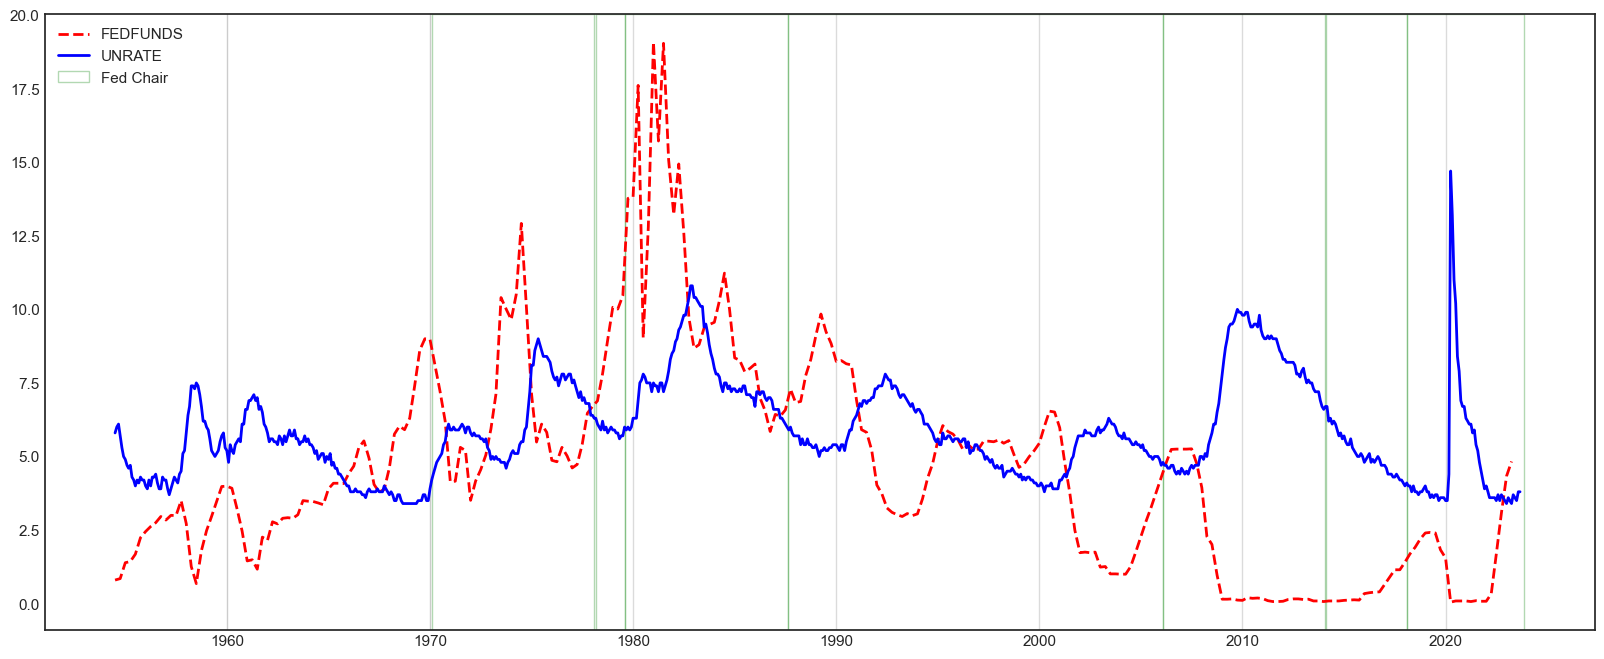

In [131]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)
ax.plot(misery_df.index, misery_df['UNRATE'], color='blue',linewidth=2)

# Plotting recession bars
for i,row in chair_df.iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], edgecolor='green', facecolor='white', alpha=0.3)
    #print()
    
ax.legend(["FEDFUNDS","UNRATE",'Fed Chair'])
plt.show()

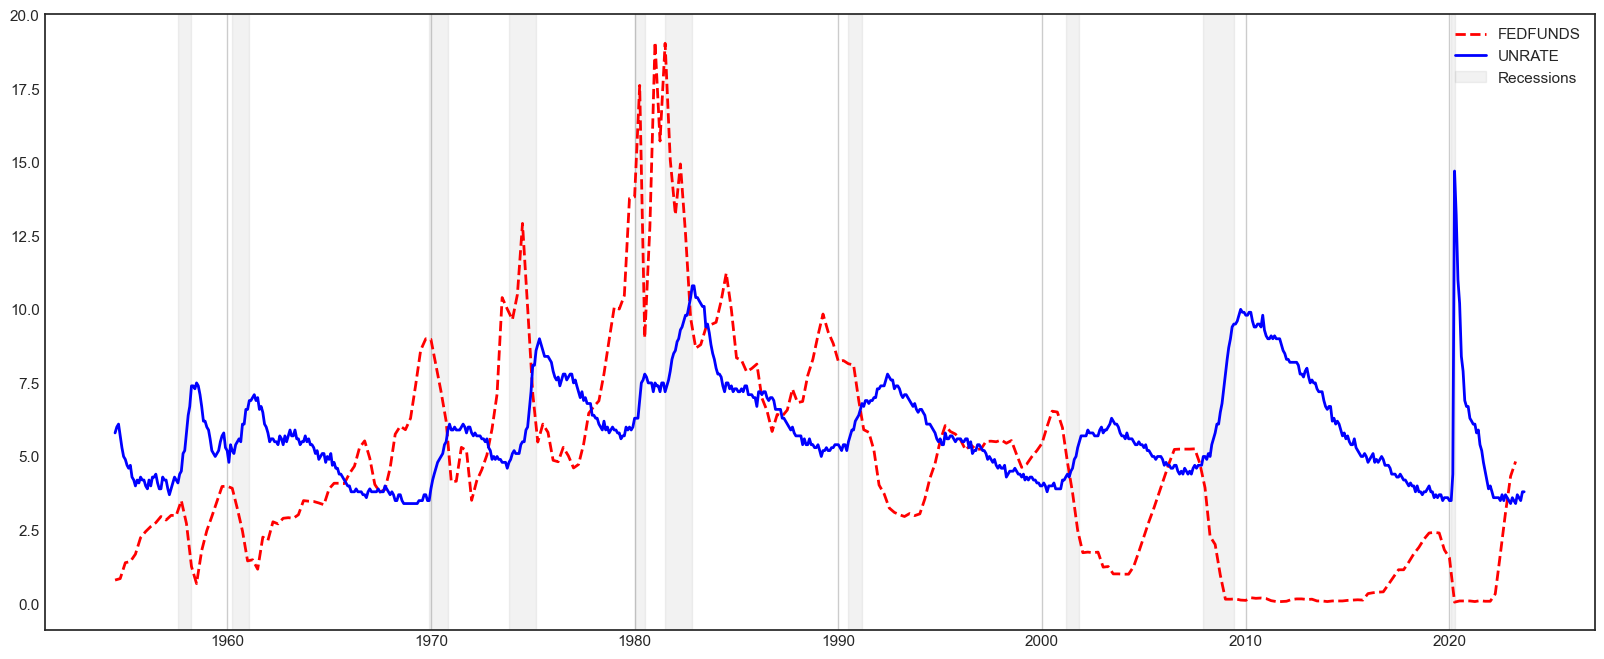

In [135]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()


# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)
ax.plot(misery_df.index, misery_df['UNRATE'], color='blue',linewidth=2)

# Plotting recession bars
for i,row in recession_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
    #print()
    
ax.legend(["FEDFUNDS","UNRATE",'Recessions'])
plt.show()